# Answering Business Questions using SQL

## About

Analyse media library from Chinook database

## Goal

 - Write a SQL query to extract the relevant data
 - Create plots where necessary to visualize the data
 - Write a short paragraph, drawing conclusions and explaining the data and/or visualizations.

### [Database](https://github.com/lerocha/chinook-database)
The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.

### Data base scheme
![Data base scheme](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

In [1]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

In [2]:
db = 'chinook.db'

Functions for connection wrapping

In [3]:
def run_query(query):
   with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)

In [4]:
def run_command(comm):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        return conn.execute(comm)

In [5]:
def show_tables():
    query = '''
            SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table","view");
            '''
    return run_query(query)

In [6]:
# database tables list
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Determine the most popular genres in the United States

In [7]:
query = '''
        WITH tracks_sold_in_US AS 
            (
            SELECT
                il.invoice_line_id,
                il.quantity as quantity,
                il.track_id
            FROM invoice_line as il
            LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
            WHERE i.billing_country = "USA"
            )
        
        SELECT
            gid.name as genre,
            SUM(tracks_sold_in_US.quantity) as abs_sells,
            SUM(tracks_sold_in_US.quantity) /
                (
                    SELECT
                        CAST(SUM(tracks_sold_in_US.quantity) as FLOAT) t_c
                    FROM tracks_sold_in_US
                ) as per_sells
            from tracks_sold_in_US
            LEFT JOIN track t ON t.track_id = tracks_sold_in_US.track_id
            LEFT JOIN genre gid ON gid.genre_id = t.genre_id
            GROUP BY 1
            ORDER BY 3 DESC;
'''

In [8]:
top_us_genres = run_query(query)
print(top_us_genres)

                 genre  abs_sells  per_sells
0                 Rock        561   0.533777
1   Alternative & Punk        130   0.123692
2                Metal        124   0.117983
3             R&B/Soul         53   0.050428
4                Blues         36   0.034253
5          Alternative         35   0.033302
6                Latin         22   0.020932
7                  Pop         22   0.020932
8          Hip Hop/Rap         20   0.019029
9                 Jazz         14   0.013321
10      Easy Listening         13   0.012369
11              Reggae          6   0.005709
12   Electronica/Dance          5   0.004757
13           Classical          4   0.003806
14         Heavy Metal          3   0.002854
15          Soundtrack          2   0.001903
16            TV Shows          1   0.000951


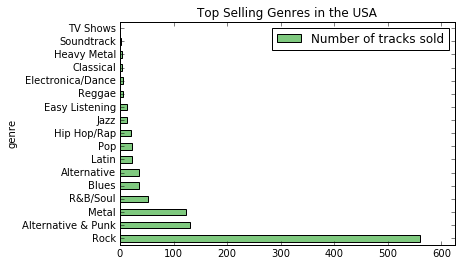

In [9]:
top_us_genres.plot.barh('genre', 'abs_sells',
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    label = 'Number of tracks sold',
    colormap=plt.cm.Accent
)

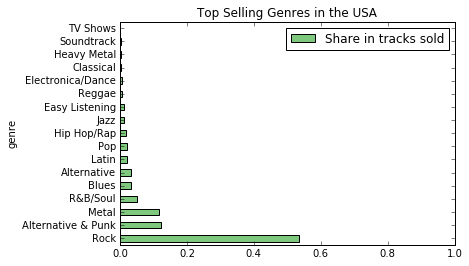

In [10]:
top_us_genres.plot.barh('genre', 'per_sells',
    title="Top Selling Genres in the USA",
    xlim=(0, 1),
    label = 'Share in tracks sold',
    colormap=plt.cm.Accent
)

### Top-3 genres in US by number of tracks sold:
 - Rock - 53% 
 - Alternative & Punk - 12%
 - Metal - 12%

Based on genres popularity, it's more preferable to add in a library following artists:

|Artist Name|Genre|
|--|-|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

## Analyze employee sales perfomance

In [11]:
query = '''
        WITH customer_total_purchases AS 
            (
            SELECT 
                c.customer_id,
                c.support_rep_id,
                SUM(i.total) total_purchases
            FROM customer c
            LEFT JOIN invoice i ON i.customer_id = c.customer_id
            GROUP BY 1
            )
        
        SELECT
            e.first_name || " " || e.last_name employee_name,
            SUM(ctp.total_purchases) total_purchases
        FROM employee e
        INNER JOIN customer_total_purchases ctp ON ctp.support_rep_id = e.employee_id
        GROUP BY 1
        ORDER BY 2 DESC
'''

In [12]:
employee_performance = run_query(query)

### Top-3 employees by performance:

In [13]:
employee_performance

,employee_name,total_purchases
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


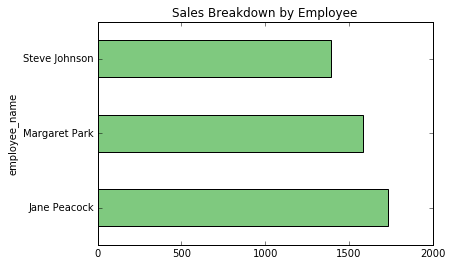

In [14]:
employee_performance.plot.barh(
    'employee_name',
    'total_purchases',
    xlim=(0,2000),
    label = 'Total sales by employee',
    title='Sales Breakdown by Employee',
    legend=False,
    colormap=plt.cm.Accent)

## Analyze and visualize the sales data for customers from each different country

In [133]:
query = '''
    WITH tot_cust AS 
        (
        SELECT country, COUNT(customer_id) total_customers FROM customer
        GROUP BY country
        ),
    country_stat_long AS
        (
        SELECT
            c.country,
            tc.total_customers total_customers,
            SUM(i.total) total_sales,
            AVG(i.total) avg_order,
            CASE
                WHEN total_customers = 1 THEN "Other"
                ELSE c.country
                END as country_
        FROM customer c
        LEFT JOIN invoice i ON i.customer_id = c.customer_id
        LEFT JOIN tot_cust tc ON tc.country = c.country
        GROUP BY 1
        ORDER BY 3 DESC
        )
    SELECT
        country_ country,
        SUM(total_customers) customers,
        SUM(total_sales) total_sales,
        SUM(avg_order) average_order,
        (CAST(total_sales as FLoat) / total_customers) customer_lifetime_value
    FROM 
        (
        SELECT
            *,
            CASE
                WHEN country_ = "Other" THEN 0
                ELSE total_customers
            END as sort
        FROM country_stat_long
        ) as cm
    GROUP BY 1
    ORDER BY sort DESC
        
'''
run_query(query)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,United Kingdom,3,245.52,8.768571,81.840000
6,Czech Republic,2,273.24,9.108000,136.620000
7,India,2,183.15,8.721429,91.575000
8,Portugal,2,185.13,6.383793,92.565000
9,Other,15,1094.94,111.676066,37.620000


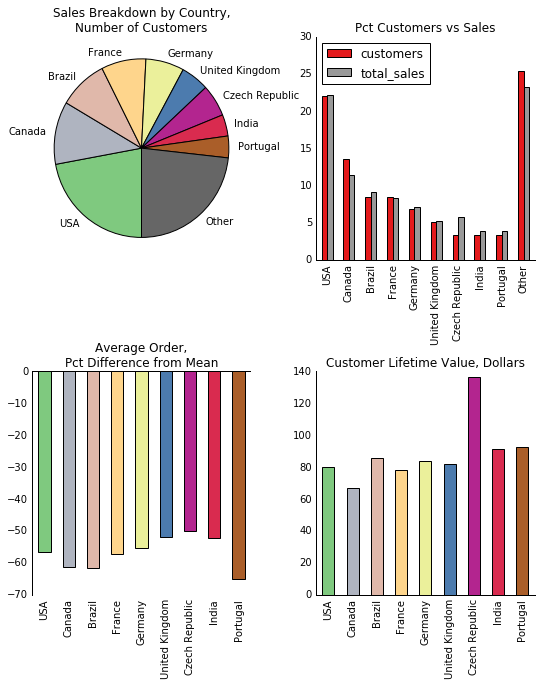

In [137]:
country_metrics = run_query(query)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top_left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
)

# top_right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks

In [143]:
query = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''
run_query(query)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recomme